# Resnet Part2

<img src="resblock.png" alt="Resblock" width="450">

We learned about what `Resnet` is in [Resnet Blog](https://galopyz.github.io/delicious-nbdev/blog/posts/2023-12-04-Resnet/). However, we didn't train it, so we have no idea how much better it is than just convolutional layers. In this blog, we will train and find out how much better we can do.

## Import libraries

In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.xtras import *

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [3]:
dls = get_dls(num_workers=2)
xb, yb = next(iter(dls.train))
xb.shape, yb

(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4,  ..., 8, 0, 3]))

## Convolutional net

Let's start with a conv net and go from there. In [Schedular blog](https://galopyz.github.io/delicious-nbdev/blog/posts/2023-11-17-Scheduler/), we had four convolutional layers. To improve the score, we can add two more layers. One layer to make it deeper and increases the number of features dimension to 256. Another layer is the first layer that uses stride of one and increases the feature dimension to 8. Let's see how that makes a difference.

In [4]:
def get_cbs(**kwargs):
    metrics = MetricsCB(**kwargs)
    cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
    return cbs

In [5]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
cbs = get_cbs(accuracy=MulticlassAccuracy())

nfs = [8,16,32,64,128,256]
def get_model():
    layers = [conv(1, 8, stride=1, act=act_gr, norm=nn.BatchNorm2d)]
    layers += [conv(nfs[i], nfs[i+1], act=act_gr, norm=nn.BatchNorm2d) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(nfs[-1], 10)]
    return nn.Sequential(*layers).apply(iw)

In [6]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).summary()

Tot params:  396986


|Module|Input|Output|Num params|
|--|--|--|--|
|Sequential|(1024, 1, 28, 28)|(1024, 8, 28, 28)|96|
|Sequential|(1024, 8, 28, 28)|(1024, 16, 14, 14)|1200|
|Sequential|(1024, 16, 14, 14)|(1024, 32, 7, 7)|4704|
|Sequential|(1024, 32, 7, 7)|(1024, 64, 4, 4)|18624|
|Sequential|(1024, 64, 4, 4)|(1024, 128, 2, 2)|74112|
|Sequential|(1024, 128, 2, 2)|(1024, 256, 1, 1)|295680|
|AdaptiveAvgPool2d|(1024, 256, 1, 1)|(1024, 256, 1, 1)|0|
|Flatten|(1024, 256, 1, 1)|(1024, 256)|0|
|Linear|(1024, 256)|(1024, 10)|2570|


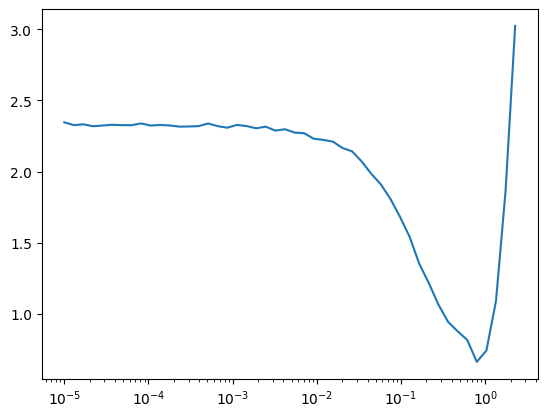

In [7]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).lr_find()

In [8]:
def get_sched(lr, epochs, dls=dls):
    tmax = epochs * len(dls.train)
    sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
    return BatchSchedCB(sched)

accuracy,loss,epoch,train,time
0.817,0.523,0,True,00:02
0.831,0.669,0,False,00:00
0.873,0.352,1,True,00:02
0.877,0.363,1,False,00:00
0.904,0.263,2,True,00:02
0.897,0.273,2,False,00:00
0.925,0.201,3,True,00:02
0.915,0.233,3,False,00:00
0.943,0.154,4,True,00:02
0.921,0.220,4,False,00:00


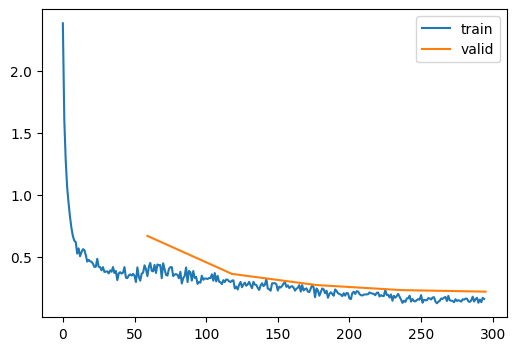

In [9]:
lr, epochs = 6e-2, 5
xtras = [get_sched(lr, epochs)]
learn = TrainLearner(get_model(), dls, F.cross_entropy, cbs=cbs+xtras, opt_func=optim.AdamW)
learn.fit(epochs)

That's an improvement. However, we want to do better. Let's use `ConvBlock`, which doubles the number of convnets.

## ConvBlock

`ConvBlock` simply has two convolutional layers. Second conv has the stride of the argument and changes the number of features.

In [10]:
class ConvBlock(nn.Module):
    def __init__(self, ni, nf, ks=3, stride=2, act=act_gr, norm=nn.BatchNorm2d):
        super().__init__()
        self.conv1 = conv(ni, ni, ks=ks, stride=1, act=act, norm=norm)
        self.conv2 = conv(ni, nf, ks=ks, stride=stride, act=act, norm=norm)
    
    def forward(self, x):
        return self.conv2(self.conv1(x))

In [11]:
def get_model():
    layers = [ConvBlock(1, 8, stride=1, act=act_gr, norm=nn.BatchNorm2d)]
    layers += [ConvBlock(nfs[i], nfs[i+1], act=act_gr, norm=nn.BatchNorm2d) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(nfs[-1], 10)]
    return nn.Sequential(*layers).apply(iw)

In [12]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).summary()

Tot params:  594158


|Module|Input|Output|Num params|
|--|--|--|--|
|ConvBlock|(1024, 1, 28, 28)|(1024, 8, 14, 14)|108|
|ConvBlock|(1024, 8, 14, 14)|(1024, 16, 7, 7)|1800|
|ConvBlock|(1024, 16, 7, 7)|(1024, 32, 4, 4)|7056|
|ConvBlock|(1024, 32, 4, 4)|(1024, 64, 2, 2)|27936|
|ConvBlock|(1024, 64, 2, 2)|(1024, 128, 1, 1)|111168|
|ConvBlock|(1024, 128, 1, 1)|(1024, 256, 1, 1)|443520|
|AdaptiveAvgPool2d|(1024, 256, 1, 1)|(1024, 256, 1, 1)|0|
|Flatten|(1024, 256, 1, 1)|(1024, 256)|0|
|Linear|(1024, 256)|(1024, 10)|2570|


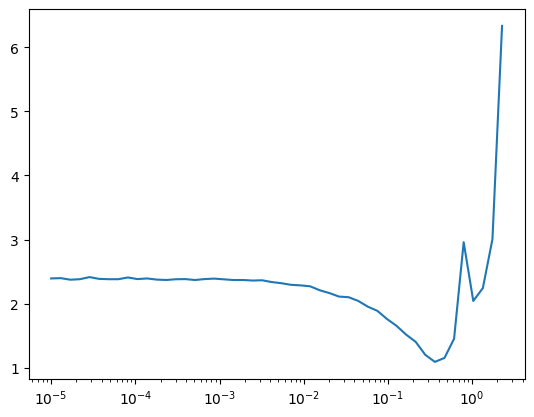

In [13]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).lr_find()

accuracy,loss,epoch,train,time
0.788,0.589,0,True,00:02
0.764,2.427,0,False,00:00
0.841,0.444,1,True,00:02
0.827,0.621,1,False,00:00
0.877,0.331,2,True,00:02
0.857,0.398,2,False,00:00
0.899,0.269,3,True,00:02
0.890,0.293,3,False,00:00
0.914,0.230,4,True,00:02
0.900,0.275,4,False,00:00


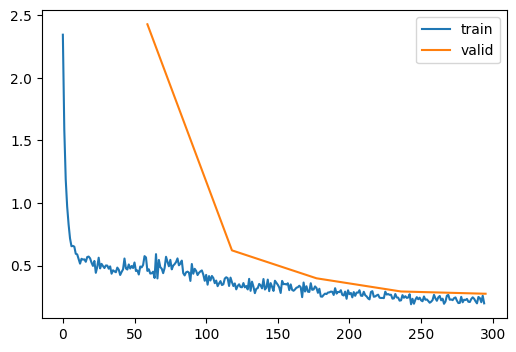

In [14]:
lr, epochs = 8e-2, 5
xtras = [get_sched(lr, epochs)]
learn = TrainLearner(get_model(), dls, F.cross_entropy, cbs=cbs+xtras, opt_func=optim.AdamW)
learn.fit(epochs)

That's not very great. We can improve this with carefully redesigning each convnets in the block.

### Modifying `ConvBlock`

Instead of changing number of features and stride at the same, it might be useful to separate them out. First, we increase the features with stride one. It's like paying closely attention to details and saving them into bigger number of features.

In [15]:
class ConvBlock(nn.Module):
    def __init__(self, ni, nf, ks=3, stride=2, act=act_gr, norm=nn.BatchNorm2d):
        super().__init__()
        self.conv1 = conv(ni, nf, ks=ks, stride=1, act=act, norm=norm)
        self.conv2 = conv(nf, nf, ks=ks, stride=stride, act=act, norm=norm)
    
    def forward(self, x):
        return self.conv2(self.conv1(x))

In [16]:
def get_model():
    layers = [ConvBlock(1, 8, stride=1, act=act_gr, norm=nn.BatchNorm2d)]
    layers += [ConvBlock(nfs[i], nfs[i+1], act=act_gr, norm=nn.BatchNorm2d) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(nfs[-1], 10)]
    return nn.Sequential(*layers).apply(iw)

In [17]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).summary()

Tot params:  1184738


|Module|Input|Output|Num params|
|--|--|--|--|
|ConvBlock|(1024, 1, 28, 28)|(1024, 8, 28, 28)|696|
|ConvBlock|(1024, 8, 28, 28)|(1024, 16, 14, 14)|3552|
|ConvBlock|(1024, 16, 14, 14)|(1024, 32, 7, 7)|14016|
|ConvBlock|(1024, 32, 7, 7)|(1024, 64, 4, 4)|55680|
|ConvBlock|(1024, 64, 4, 4)|(1024, 128, 2, 2)|221952|
|ConvBlock|(1024, 128, 2, 2)|(1024, 256, 1, 1)|886272|
|AdaptiveAvgPool2d|(1024, 256, 1, 1)|(1024, 256, 1, 1)|0|
|Flatten|(1024, 256, 1, 1)|(1024, 256)|0|
|Linear|(1024, 256)|(1024, 10)|2570|


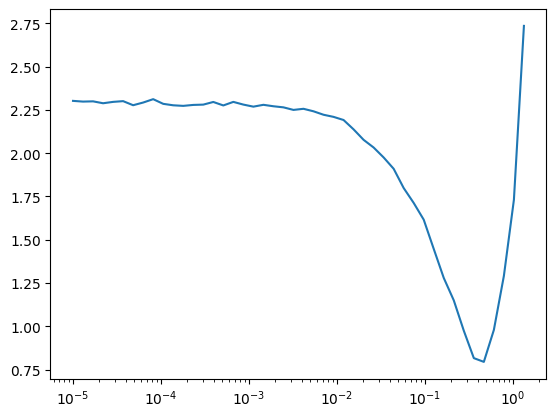

In [18]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).lr_find()

accuracy,loss,epoch,train,time
0.811,0.519,0,True,00:02
0.691,2.792,0,False,00:00
0.857,0.405,1,True,00:02
0.853,0.403,1,False,00:00
0.904,0.260,2,True,00:02
0.881,0.325,2,False,00:00
0.925,0.204,3,True,00:02
0.915,0.233,3,False,00:00
0.942,0.157,4,True,00:02
0.926,0.208,4,False,00:00


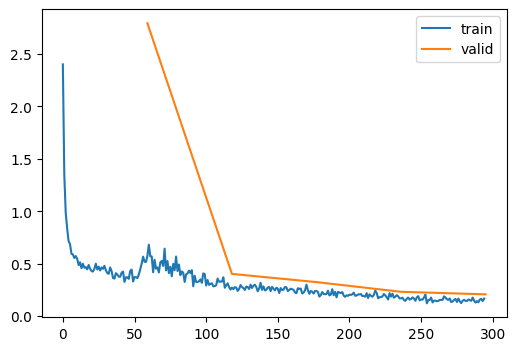

In [19]:
lr, epochs = 8e-2, 5
xtras = [get_sched(lr, epochs)]
learn = TrainLearner(get_model(), dls, F.cross_entropy, cbs=cbs+xtras, opt_func=optim.AdamW)
learn.fit(epochs)

That's better! How about if we stride first? I don't think it would be better than the previous approach, but let's see how it performs.

In [20]:
class ConvBlock(nn.Module):
    def __init__(self, ni, nf, ks=3, stride=2, act=act_gr, norm=nn.BatchNorm2d):
        super().__init__()
        self.conv1 = conv(ni, ni, ks=ks, stride=stride, act=act, norm=norm)
        self.conv2 = conv(ni, nf, ks=ks, stride=1, act=act, norm=norm)
    
    def forward(self, x):
        return self.conv2(self.conv1(x))

In [21]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).summary()

Tot params:  594158


|Module|Input|Output|Num params|
|--|--|--|--|
|ConvBlock|(1024, 1, 28, 28)|(1024, 8, 28, 28)|108|
|ConvBlock|(1024, 8, 28, 28)|(1024, 16, 14, 14)|1800|
|ConvBlock|(1024, 16, 14, 14)|(1024, 32, 7, 7)|7056|
|ConvBlock|(1024, 32, 7, 7)|(1024, 64, 4, 4)|27936|
|ConvBlock|(1024, 64, 4, 4)|(1024, 128, 2, 2)|111168|
|ConvBlock|(1024, 128, 2, 2)|(1024, 256, 1, 1)|443520|
|AdaptiveAvgPool2d|(1024, 256, 1, 1)|(1024, 256, 1, 1)|0|
|Flatten|(1024, 256, 1, 1)|(1024, 256)|0|
|Linear|(1024, 256)|(1024, 10)|2570|


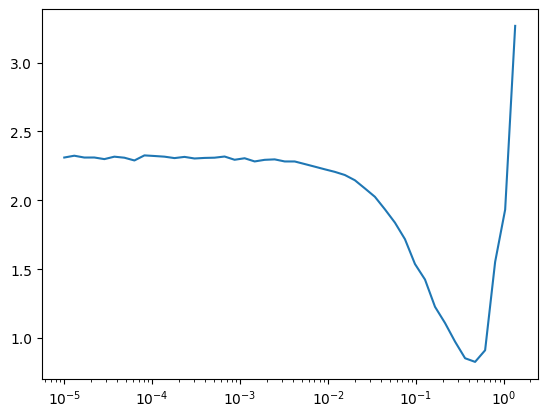

In [22]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).lr_find()

accuracy,loss,epoch,train,time
0.796,0.563,0,True,00:02
0.739,1.534,0,False,00:00
0.844,0.445,1,True,00:02
0.805,0.698,1,False,00:00
0.890,0.295,2,True,00:02
0.843,0.435,2,False,00:00
0.911,0.239,3,True,00:02
0.901,0.263,3,False,00:00
0.928,0.195,4,True,00:02
0.913,0.235,4,False,00:00


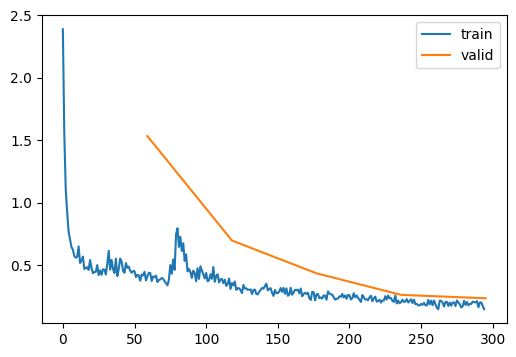

In [23]:
lr, epochs = 1e-1, 5
xtras = [get_sched(lr, epochs)]
learn = TrainLearner(get_model(), dls, F.cross_entropy, cbs=cbs+xtras, opt_func=optim.AdamW)
learn.fit(epochs)

As expected, first modification is the best. Let's use resnet we learned in [Resnet blog](https://galopyz.github.io/delicious-nbdev/blog/posts/2023-12-04-Resnet/).

## ResBlock

For `ResBlock`, we do not want to have activation layer for the second convnet. So, that's what `ConvBlock2` does.

In [24]:
class ConvBlock2(nn.Module):
    def __init__(self, ni, nf, ks=3, stride=2, act=act_gr, norm=nn.BatchNorm2d):
        super().__init__()
        self.conv1 = conv(ni, nf, ks=ks, stride=1, act=act, norm=norm)
        self.conv2 = conv(nf, nf, ks=ks, stride=stride, act=False, norm=norm)
    
    def forward(self, x):
        return self.conv2(self.conv1(x))

In [25]:
class ResBlock(nn.Module):
    def __init__(self, ni, nf, ks=3, stride=2, act=act_gr, norm=nn.BatchNorm2d):
        super().__init__()
        self.id_conv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None, norm=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.convs = ConvBlock2(ni, nf, ks=ks, stride=stride, act=act, norm=norm)
        self.act = act()
    
    def forward(self, x):
        return self.act(self.convs(x) + self.id_conv(self.pool(x)))

In [26]:
def get_model(act=act_gr):
    layers = [ResBlock(1, 8, stride=1, act=act, norm=nn.BatchNorm2d)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=nn.BatchNorm2d) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(nfs[-1], 10)]
    return nn.Sequential(*layers).apply(iw)

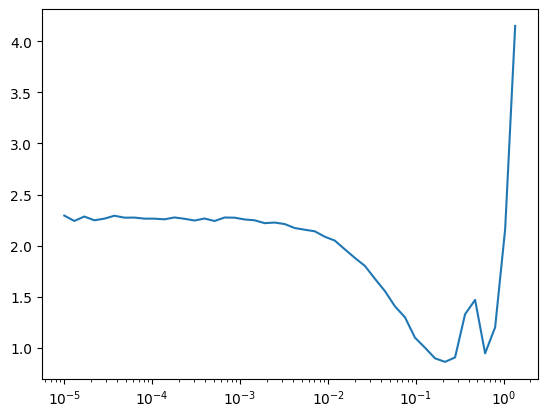

In [27]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).lr_find()

accuracy,loss,epoch,train,time
0.809,0.537,0,True,00:02
0.815,0.601,0,False,00:00
0.879,0.324,1,True,00:02
0.877,0.343,1,False,00:00
0.913,0.236,2,True,00:02
0.894,0.281,2,False,00:00
0.933,0.179,3,True,00:02
0.918,0.226,3,False,00:00
0.954,0.127,4,True,00:02
0.923,0.214,4,False,00:00


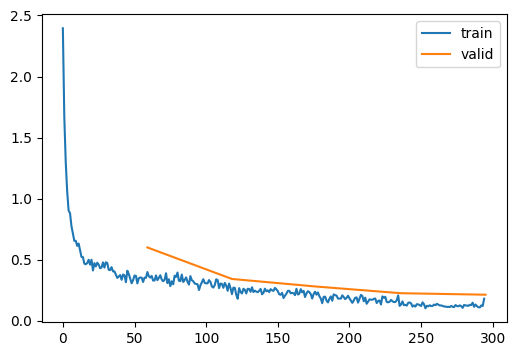

In [28]:
lr, epochs = 2e-2, 5
xtras = [get_sched(lr, epochs)]
learn = TrainLearner(get_model(), dls, F.cross_entropy, cbs=cbs+xtras, opt_func=optim.AdamW)
learn.fit(epochs)

This is about the same as using normal convolutional nets. However, the real power of resnet comes from deeper layers. In much deeper networks (over 100 layers), normal `ConvBlocks` will collapse eventually and perform worse than shallower networks. 

### `nn.ReLU` vs. `GeneralRelu`

Now that we are using much deeper networks, how much does it matter if we change activation functions to `nn.ReLU` from `GeneralRelu`? 

In [29]:
def get_model(act=act_gr):
    layers = [ResBlock(1, 8, stride=1, act=act, norm=nn.BatchNorm2d)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=nn.BatchNorm2d) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(nfs[-1], 10)]
    return nn.Sequential(*layers).apply(init_weights)

accuracy,loss,epoch,train,time
0.804,0.553,0,True,00:02
0.811,0.578,0,False,00:00
0.891,0.296,1,True,00:02
0.882,0.344,1,False,00:00
0.915,0.231,2,True,00:02
0.896,0.288,2,False,00:00
0.937,0.172,3,True,00:02
0.913,0.234,3,False,00:00
0.955,0.124,4,True,00:02
0.925,0.207,4,False,00:00


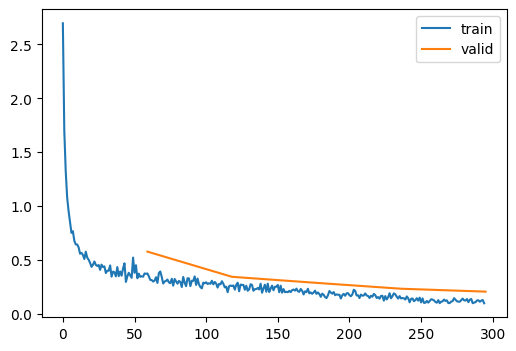

In [30]:
lr, epochs = 2e-2, 5
xtras = [get_sched(lr, epochs)]
learn = TrainLearner(get_model(act=nn.ReLU), dls, F.cross_entropy, cbs=cbs+xtras, opt_func=optim.AdamW)
learn.fit(epochs)

There is almost no difference in accuracy. Maybe because we are using Batch Normalization, they are corrected. Well, it runs faster, so we will change back to `nn.ReLU`.

## Wider Resnet

Another improvement we can make is make it wider with a bigger kernel size of 5. To compensate, we can increase the feature size to 16.

In [31]:
nfs = [16,32,64,128,256]

def get_model(act=nn.ReLU):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=nn.BatchNorm2d)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=nn.BatchNorm2d) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(nfs[-1], 10)]
    return nn.Sequential(*layers).apply(init_weights)

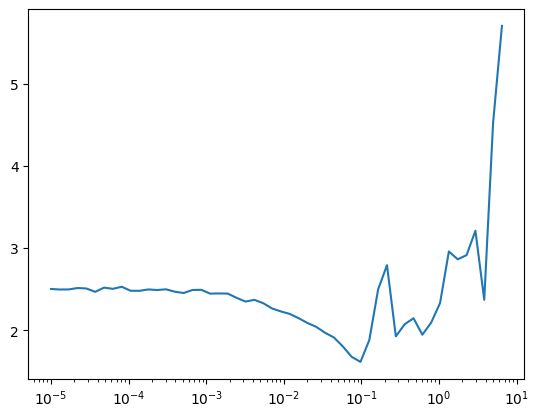

In [32]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).lr_find()

accuracy,loss,epoch,train,time
0.816,0.522,0,True,00:02
0.568,1.813,0,False,00:00
0.886,0.307,1,True,00:02
0.881,0.331,1,False,00:00
0.914,0.232,2,True,00:02
0.912,0.240,2,False,00:00
0.936,0.172,3,True,00:02
0.925,0.206,3,False,00:00
0.958,0.118,4,True,00:02
0.931,0.193,4,False,00:00


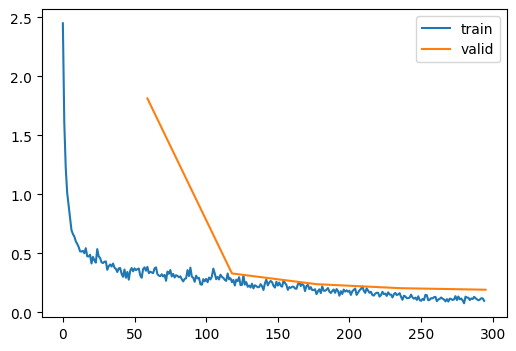

In [37]:
lr, epochs = 3e-2, 5
xtras = [get_sched(lr, epochs)]
learn = TrainLearner(get_model(act=nn.ReLU), dls, F.cross_entropy, cbs=cbs+xtras, opt_func=optim.AdamW)
learn.fit(epochs)

That's an improvement again! We reached 93.1% accuracy.

## Conclusion

We used `Resnet` in this blog and used different kinds of `ConvBlock`s. We also used wider version to improve accuracy. However, we are not done yet. There are some more improvements we can make. In the future blogs, we will learn about data augmentation, test time augmentation (TTA), ensembling, and dropout.